# Nota Importante
O propósito deste notebook é preparar uma base com dados geográficos combinados com as informações dos blocos que treinaram nosso modelo.
- Bloco é uma área geográfica que agrupa residências, pode ser um quarteirão, um bairro ou até uma região inteira, dependendo da densidade populacional. Nossos dados geográficos não serão detalhados por esses blocos, mas sim por condado;
- Condado por sua vez, é uma região geográfica que agrupa cidades e são subdivisões dos estados, com certa autonomia administrativa, o que simplificará nossa interface para interação com o usuário e previsão de preços de casas nesses condado;
- Alguns dados, vamos pedir na interface para detalhar o imóvel e renda, mas para alcançar essa simplificação, vamos utilizar a mediana e as modas dos dados de todos os blocos contidos naquele condado.
- Mediana para tentar evitar interferência de outliers. Alguns condados, se observado no mapa, são rurais ou desérticos e sua população acaba se concentando em pontos específicos, com pequenos grupos dispersos que seriam outliers;

Obviamente, essa simplificação sacrificará os detalhes para entrada no modelo, que foi treinado por blocos. Mas também permitirá que o usuário tenha uma interface limpa, funcional e intuitiva para alcançar sua estimativa de preços para o imóvel.






---

Leia o arquivo [README.md](../README.md) para detalhes sobre a base o projeto.

Leia o arquivo de [01_dicionario_de_dados.md](../referencias/01_dicionario_de_dados.md) para detalhes sobre a base.

Ao importar esse arquivo [src.graficos](./src/graficos.py), em tema seaborn é aplicado.

# Importações e configurações

In [1]:
import geopandas as gpd # https://geopandas.org/en/stable/index.html
from joblib import dump
import pandas as pd
from shapely.geometry import Point
from src.config import (
    DADOS_LIMPOS,
    DADOS_MEDIAN,
    DADOS_GEO_DATAFRAME,
    DADOS_GEO_ORIGINAIS,
)
from src.graficos import SCATTER_ALPHA

In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.6f}'.format

# Importando e preprarando os dados

## Carregando os dados sem outliers

Origem: [01-ild-eda.ipynb](01-ild-eda.ipynb)

- `median_income`: renda mediana no grupo de blocos (em dezenas de milhares de dólares)
- `housing_median_age`: idade mediana das casas no grupo de blocos
- `total_rooms`: número cômodos no grupo de blocos
- `total_bedrooms`: número de quartos no grupo de blocos
- `population`: população do grupo de blocos
- `households`: domicílios no grupo de blocos
- `latitude`: latitude do grupo de blocos
- `longitude`: longitude do grupo de blocos
- `ocean_proximity`: proximidade do oceano
  - `NEAR BAY`: perto da baía
  - `<1H OCEAN`: a menos de uma hora do oceano
  - `INLAND`: no interior
  - `NEAR OCEAN`: perto do oceano
- `median_house_value`: valor mediano das casas no grupo de blocos (em dólares)
- `median_income_cat`: categorias baseadas no valor da mediana do salário anual -> `median_income`
- `housing_median_age_cat`: categorias baseadas no valor da mediana das idades das casas -> `housing_median_age`
- `population_cat`: categorias baseadas no tamanho da população -> `population`
- `rooms_per_household`: `total_rooms` / `households`
- `population_per_household`: `population` / `households`
- `bedrooms_per_room`: `total_bedrooms` / `total_rooms`

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.325200,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.301400,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.080400,226700,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.125000,140000,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.991100,158700,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.343676,2.362768,0.203216


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18375 entries, 0 to 18374
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 18375 non-null  float32 
 1   latitude                  18375 non-null  float32 
 2   housing_median_age        18375 non-null  uint8   
 3   total_rooms               18375 non-null  uint16  
 4   total_bedrooms            18375 non-null  uint16  
 5   population                18375 non-null  uint16  
 6   households                18375 non-null  uint16  
 7   median_income             18375 non-null  float32 
 8   median_house_value        18375 non-null  uint32  
 9   ocean_proximity           18375 non-null  category
 10  median_income_cat         18375 non-null  category
 11  housing_median_age_cat    18375 non-null  category
 12  population_cat            18375 non-null  category
 13  rooms_per_household       18375 non-null  floa

## Carregando o mapa dos condados (arquivo geojson)
O geopandas permite carregar o arquivo geojson e trabalhar com ele como um dataframe do pandas.

In [5]:
gdf_counties = gpd.read_file(filename=DADOS_GEO_ORIGINAIS)

gdf_counties.head()

,name,cartodb_id,created_at,updated_at,geometry
0,Alameda,1,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884..."
1,Alpine,2,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.07239 38.70277, -119.96495 38.7..."
2,Amador,3,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.02726 38.48925, -121.02741 38.5..."
3,Butte,4,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.87925 39.30361, -121.90831 39.3..."
4,Calaveras,5,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.87605 38.02889, -120.91875 38.0..."


In [6]:
gdf_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   name        58 non-null     object             
 1   cartodb_id  58 non-null     int32              
 2   created_at  58 non-null     datetime64[ms, UTC]
 3   updated_at  58 non-null     datetime64[ms, UTC]
 4   geometry    58 non-null     geometry           
dtypes: datetime64[ms, UTC](2), geometry(1), int32(1), object(1)
memory usage: 2.2+ KB


In [7]:
# excluindo colunas desnecessárias
gdf_counties.drop(
    columns=['cartodb_id', 'created_at', 'updated_at'],
    axis='columns',
    inplace=True,
)

# renomeando colunas
gdf_counties.rename(
    columns={'name': 'condado'},
    inplace=True,
)

gdf_counties.head()

,condado,geometry
0,Alameda,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884..."
1,Alpine,"POLYGON ((-120.07239 38.70277, -119.96495 38.7..."
2,Amador,"POLYGON ((-121.02726 38.48925, -121.02741 38.5..."
3,Butte,"POLYGON ((-121.87925 39.30361, -121.90831 39.3..."
4,Calaveras,"POLYGON ((-120.87605 38.02889, -120.91875 38.0..."


<Axes: >

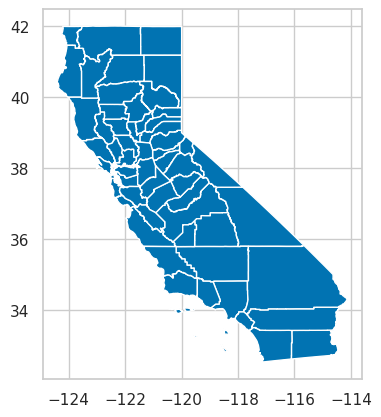

In [8]:
gdf_counties.plot()

# Transformando nosso dataframe de dados em geográfico e cruzando com nosso mapa
- Nosso mapa é um conjunto de polígonos.
- Nossos dados tem latitude e longitude que podem ser colocados dentro dos poligonos dos mapas se indicados como pontos geográficos.

In [9]:
# para criar um ponto a longitude(eixo X) vem primeiro, que é o contário do google maps.
pontos_blocos = [Point(long, lat) for long, lat in zip(df['longitude'], df['latitude'])]

pontos_blocos[:5]

[<POINT (-122.23 37.88)>,
 <POINT (-122.22 37.86)>,
 <POINT (-122.26 37.84)>,
 <POINT (-122.26 37.85)>,
 <POINT (-122.26 37.84)>]

In [10]:
gdf = gpd.GeoDataFrame(data=df, geometry=pontos_blocos)

gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room,geometry
0,-122.230003,37.880001,41,880,129,322,126,8.325200,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.984127,2.555556,0.146591,POINT (-122.23 37.88)
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.301400,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.238137,2.109842,0.155797,POINT (-122.22 37.86)
2,-122.260002,37.840000,42,2555,665,1206,595,2.080400,226700,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.294117,2.026891,0.260274,POINT (-122.26 37.84)
3,-122.260002,37.849998,50,1120,283,697,264,2.125000,140000,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.242424,2.640152,0.252679,POINT (-122.26 37.85)
4,-122.260002,37.840000,50,2239,455,990,419,1.991100,158700,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.343676,2.362768,0.203216,POINT (-122.26 37.84)


In [11]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18375 entries, 0 to 18374
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 18375 non-null  float32 
 1   latitude                  18375 non-null  float32 
 2   housing_median_age        18375 non-null  uint8   
 3   total_rooms               18375 non-null  uint16  
 4   total_bedrooms            18375 non-null  uint16  
 5   population                18375 non-null  uint16  
 6   households                18375 non-null  uint16  
 7   median_income             18375 non-null  float32 
 8   median_house_value        18375 non-null  uint32  
 9   ocean_proximity           18375 non-null  category
 10  median_income_cat         18375 non-null  category
 11  housing_median_age_cat    18375 non-null  category
 12  population_cat            18375 non-null  category
 13  rooms_per_household       18375 non-nu

Os pontos(geometry) já são reconhecidos, tanto que podemos fazer um plot, assim como fizemos para o mapa.

<Axes: >

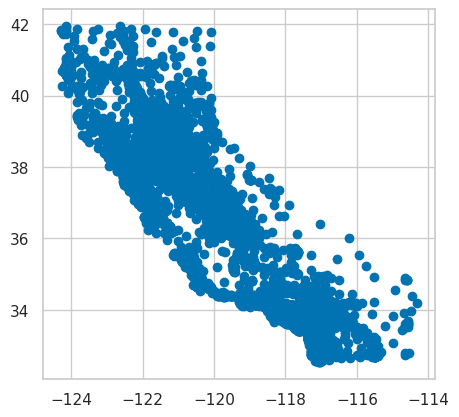

In [12]:
gdf.plot()

In [13]:
# todos os dados estão no geodataframe
# não precisamos mais do dataframe, nem da lista de pontos
del df, pontos_blocos

## Configurando o sistema de referência geográfica
Um Sistema de Referência de Coordenadas (CRS, do inglês *Coordinate Reference System*) é o conjunto de regras que define como os dados geoespaciais são projetados na superfície da Terra. Essas coordenadas podem ser expressas em diferentes sistemas, como latitudes e longitudes ou distâncias em metros.

Como veremos, nosso mapa está no sistema por latitudes e longitudes, o que é conveniente, pois são os dados que temos dos blocos também.


In [14]:
# verificando o CRS do arquivo geográfico carregado - tipo de codificação geográfica
gdf_counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Nossos dados receberam o ponto de longitude e latitude, mas não informamos ainda ao geopandas que esse é o sistema que queremos utilizar para cruzamentos.

Vamos fazer isso agora.

In [15]:
# nosso geodataframe com dados dos blocos e pontos(long, lat) ainda não tem um sistema de codificação geográfica
gdf.crs

In [16]:
# indicando que o sistema utilizado é de latitude e longitude, o mesmo do mapa carregado anteriomente
# existem outras formas de configurar isso e até de trocar uma pré-existente, mas clonar o crs do nosso mapa é mais intuitivo.
gdf.set_crs(
    crs=gdf_counties.crs,
    inplace=True
)

gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Relacionando os pontos com o mapa

- Pontos podem estar contidos em polígonos;
- Poligonos podem conter pontos;
- Polígonos podem ter pontos centroids;
- Distancias entre pontos podem ser calculadas.

Isso vai permitir que façamos cruzamentos entre os dois geodataframes e ligar cada registro de dados a um condado.

https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins

https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html

In [17]:
# o cruzamento é feito considerando as geometrias dos dois geodataframes
gdf = gpd.sjoin(
    left_df=gdf, # pontos no globo
    right_df=gdf_counties, # mapa de condados da california
    how='left', # olhando para os dados da esquerda (left_df)
    predicate='within', # vendo se os dados do [how] (left_df) estão dentro da outra parte (right_df)
)

gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,housing_median_age_cat,population_cat,rooms_per_household,population_per_household,bedrooms_per_room,geometry,index_right,condado
0,-122.230003,37.880001,41,880,129,322,126,8.325200,452600,NEAR BAY,6 <= x,40 <= x,0 <= x < 500,6.984127,2.555556,0.146591,POINT (-122.23 37.88),0.000000,Alameda
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.301400,358500,NEAR BAY,6 <= x,20 <= x < 30,2000 <= x,6.238137,2.109842,0.155797,POINT (-122.22 37.86),0.000000,Alameda
2,-122.260002,37.840000,42,2555,665,1206,595,2.080400,226700,NEAR BAY,1.5 <= x < 3,40 <= x,1000 <= x < 1500,4.294117,2.026891,0.260274,POINT (-122.26 37.84),0.000000,Alameda
3,-122.260002,37.849998,50,1120,283,697,264,2.125000,140000,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,4.242424,2.640152,0.252679,POINT (-122.26 37.85),0.000000,Alameda
4,-122.260002,37.840000,50,2239,455,990,419,1.991100,158700,NEAR BAY,1.5 <= x < 3,40 <= x,500 <= x < 1000,5.343676,2.362768,0.203216,POINT (-122.26 37.84),0.000000,Alameda


`condado` no geodataframe acima é o indice encontrado no geodataframe de condados

In [18]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18375 entries, 0 to 18374
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 18375 non-null  float32 
 1   latitude                  18375 non-null  float32 
 2   housing_median_age        18375 non-null  uint8   
 3   total_rooms               18375 non-null  uint16  
 4   total_bedrooms            18375 non-null  uint16  
 5   population                18375 non-null  uint16  
 6   households                18375 non-null  uint16  
 7   median_income             18375 non-null  float32 
 8   median_house_value        18375 non-null  uint32  
 9   ocean_proximity           18375 non-null  category
 10  median_income_cat         18375 non-null  category
 11  housing_median_age_cat    18375 non-null  category
 12  population_cat            18375 non-null  category
 13  rooms_per_household       18375 non-null  f

Nas informações acima podemos ver que temos nulos no `condado`. Isso indica que não conseguimos cruzar todos os pontos com seu respectivo condado.
- O bloco usa uma longitude e latitude para representá-lo, não sabemos como a medição de coordenadas foi feita para a base em 1990;
- Foi registrado com alguma média, mediana? Com o ponto onde o veículo deixou o agente do censo inicialmente? Não cabe se aprofundar nisso;

Vamos ver quem são esses registros sem `condado`, para entender a situação e tomar alguma medida para sanar o problema e/ou eliminar o registro?

In [19]:
gdf['condado'].isnull().sum()

np.int64(197)

In [20]:
linhas_faltantes = gdf[gdf['condado'].isnull()].index

linhas_faltantes

Index([   47,   271,   272,   310,   314,   317,   321,   322,   327,   328,
       ...
       16700, 16728, 17152, 17987, 17988, 17990, 18024, 18025, 18048, 18053],
      dtype='int64', length=197)

In [21]:
# para criar um ponto a longitude(eixo X) vem primeiro, que é o contário do google maps.
# aqui a latitude(eixo y) é informada primeiro

pontos_ruins_google_maps = gdf.iloc[linhas_faltantes][['latitude', 'longitude']]

fnc_float_to_text = lambda x: format(x, '.6f') # função para tornar os floats em texto

pontos_ruins_google_maps['texto_busca_maps'] = \
    pontos_ruins_google_maps['latitude'].map(fnc_float_to_text) + \
    ', ' + \
    pontos_ruins_google_maps['longitude'].map(fnc_float_to_text)

pontos_ruins_google_maps

,latitude,longitude,texto_busca_maps
47,37.790001,-122.269997,"37.790001, -122.269997"
271,37.889999,-122.330002,"37.889999, -122.330002"
272,37.880001,-122.339996,"37.880001, -122.339996"
310,37.840000,-122.300003,"37.840000, -122.300003"
314,37.770000,-122.300003,"37.770000, -122.300003"
...,...,...,...
17990,34.230000,-119.290001,"34.230000, -119.290001"
18024,34.169998,-119.269997,"34.169998, -119.269997"
18025,34.150002,-119.230003,"34.150002, -119.230003"
18048,34.150002,-119.220001,"34.150002, -119.220001"


Pegando alguns exemplos acima, podemos ver que alguns pontos deram no limite com o estado de Nevada, outros sobre o oceano e etc.
São erros de precisão de como a base de blocos de casas foram criadas, mas todos estão próximos ou no limite de algum condado.

Vamos levar esses pontos para o condado mais próximo dentro da Califónia usando os centróides dos condados.
- Podemos pegar centróides de cada polígono e ver a distancia que ele tem do ponto não cruzado;
- Escolhemos a menor distancia entre qualquer centroid e o ponto não cruzado, esse será o condado por aproximação geográfica;

Isso não deve dar margem para novos nulos, mas se acontecer podemos eliminar os registros não cruzados.

In [22]:
# função para pegar o condado com a menor distancia de um ponto
def fnc_condado_mais_proximo(linha_geodataframe: gpd.GeoSeries):
    distancias = gdf_counties.centroid.distance( # pega as distancias entre cada centróide e o ponto do registro enviado
        other=linha_geodataframe['geometry'], # a geoseries ou objeto geometrico para o qual se quer encontrar a distancia, nesse caso o ponto
        align=None # None=True/Default. Se alinha automaticamente ao geoseries com base em seus indices. False preserva a ordem.
    )

    return gdf_counties.loc[
        distancias.idxmin(), # indice do condado com o centróide de menor distância do ponto
        'condado',
    ]

In [23]:
gdf.loc[linhas_faltantes, 'condado'] = gdf.loc[linhas_faltantes].apply(fnc_condado_mais_proximo, axis=1)

gdf.loc[linhas_faltantes, 'condado']

/tmp/ipykernel_18113/4060882233.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancias = gdf_counties.centroid.distance( # pega as distancias entre cada centróide e o ponto do registro enviado
/tmp/ipykernel_18113/4060882233.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancias = gdf_counties.centroid.distance( # pega as distancias entre cada centróide e o ponto do registro enviado
/tmp/ipykernel_18113/4060882233.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distancias = gdf_counties.centroid.distance( # pega as distancias entre cada centróide e o 

47       San Francisco
271      San Francisco
272      San Francisco
310      San Francisco
314      San Francisco
             ...      
17990          Ventura
18024          Ventura
18025          Ventura
18048          Ventura
18053          Ventura
Name: condado, Length: 197, dtype: object

In [24]:
gdf['condado'].isnull().sum()

np.int64(0)

Preenchemos todos os 197 condados que ainda estavam nulos

# Calculando as medianas e modas dos dados por condado

In [25]:
gdf['condado'].value_counts().to_frame()

,count
condado,
Los Angeles,5073
San Diego,1510
Orange,1503
Santa Clara,849
San Bernardino,804
...,...
Mono,17
Colusa,14
Modoc,8


In [26]:
df_medianas = gdf.groupby('condado').median(numeric_only=True)

df_medianas.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,bedrooms_per_room,index_right
condado,,,,,,,,,,,,,
Alameda,-122.129997,37.709999,35.000000,1951.500000,404.000000,1054.000000,385.500000,3.641100,189950.000000,5.104152,2.725397,0.206337,0.000000
Alpine,-119.934998,38.705002,16.500000,1756.000000,425.500000,402.500000,174.000000,2.345850,129100.000000,9.744495,2.102038,0.216182,1.000000
Amador,-120.720001,38.424999,17.000000,1785.000000,352.000000,786.500000,296.500000,3.085750,117600.000000,6.074708,2.442094,0.191623,2.000000
Butte,-121.599998,39.709999,22.000000,1875.000000,372.500000,936.500000,356.500000,2.318950,86450.000000,5.308164,2.505593,0.199738,3.000000
Calaveras,-120.544998,38.235001,16.000000,2964.500000,626.000000,960.500000,373.500000,2.680450,106150.000000,6.079977,2.457632,0.201661,4.000000


In [27]:
gdf[
    ['condado', 'ocean_proximity',
        #'median_income_cat', 'population_cat', 'housing_median_age_cat'
    ]
].groupby('condado').describe()


ocean_proximity                       
                    count unique        top freq
condado                                         
Alameda               748      3   NEAR BAY  622
Alpine                  4      1     INLAND    4
Amador                 28      1     INLAND   28
Butte                 146      1     INLAND  146
Calaveras              32      1     INLAND   32
...                   ...    ...        ...  ...
Tulare                252      1     INLAND  252
Tuolumne               54      1     INLAND   54
Ventura               359      3  <1H OCEAN  197
Yolo                   79      1     INLAND   79
Yuba                   52      1     INLAND   52

[58 rows x 4 columns]

In [28]:
df_modas = gdf[
    ['condado', 'ocean_proximity',
        # essas categorias devem ser calculadas na aplicação
        # 'median_income_cat', 'population_cat', 'housing_median_age_cat'
    ]
].groupby('condado').agg(pd.Series.mode)

df_modas

,ocean_proximity
condado,
Alameda,NEAR BAY
Alpine,INLAND
Amador,INLAND
Butte,INLAND
Calaveras,INLAND
...,...
Tulare,INLAND
Tuolumne,INLAND
Ventura,<1H OCEAN


In [29]:
df_medianas = df_medianas.merge(
    right=df_modas,
    how='inner',
    left_index=True,
    right_index=True,
)

df_medianas.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,bedrooms_per_room,index_right,ocean_proximity
condado,,,,,,,,,,,,,,
Alameda,-122.129997,37.709999,35.000000,1951.500000,404.000000,1054.000000,385.500000,3.641100,189950.000000,5.104152,2.725397,0.206337,0.000000,NEAR BAY
Alpine,-119.934998,38.705002,16.500000,1756.000000,425.500000,402.500000,174.000000,2.345850,129100.000000,9.744495,2.102038,0.216182,1.000000,INLAND
Amador,-120.720001,38.424999,17.000000,1785.000000,352.000000,786.500000,296.500000,3.085750,117600.000000,6.074708,2.442094,0.191623,2.000000,INLAND
Butte,-121.599998,39.709999,22.000000,1875.000000,372.500000,936.500000,356.500000,2.318950,86450.000000,5.308164,2.505593,0.199738,3.000000,INLAND
Calaveras,-120.544998,38.235001,16.000000,2964.500000,626.000000,960.500000,373.500000,2.680450,106150.000000,6.079977,2.457632,0.201661,4.000000,INLAND


In [30]:
df_medianas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 58 non-null     float32 
 1   latitude                  58 non-null     float32 
 2   housing_median_age        58 non-null     float64 
 3   total_rooms               58 non-null     float64 
 4   total_bedrooms            58 non-null     float64 
 5   population                58 non-null     float64 
 6   households                58 non-null     float64 
 7   median_income             58 non-null     float32 
 8   median_house_value        58 non-null     float64 
 9   rooms_per_household       58 non-null     float32 
 10  population_per_household  58 non-null     float32 
 11  bedrooms_per_room         58 non-null     float32 
 12  index_right               58 non-null     float64 
 13  ocean_proximity           58 non-null     categor

Salário e idade da casa, vamos pedir na aplicação então não precisa estar na base.

O valor da casa quem dirá é o modelo.

In [31]:
df_medianas.drop(
    columns=['housing_median_age', 'median_income', 'median_house_value'],
    axis='columns',
    inplace=True
)

df_medianas

,longitude,latitude,total_rooms,total_bedrooms,population,households,rooms_per_household,population_per_household,bedrooms_per_room,index_right,ocean_proximity
condado,,,,,,,,,,,
Alameda,-122.129997,37.709999,1951.500000,404.000000,1054.000000,385.500000,5.104152,2.725397,0.206337,0.000000,NEAR BAY
Alpine,-119.934998,38.705002,1756.000000,425.500000,402.500000,174.000000,9.744495,2.102038,0.216182,1.000000,INLAND
Amador,-120.720001,38.424999,1785.000000,352.000000,786.500000,296.500000,6.074708,2.442094,0.191623,2.000000,INLAND
Butte,-121.599998,39.709999,1875.000000,372.500000,936.500000,356.500000,5.308164,2.505593,0.199738,3.000000,INLAND
Calaveras,-120.544998,38.235001,2964.500000,626.000000,960.500000,373.500000,6.079977,2.457632,0.201661,4.000000,INLAND
...,...,...,...,...,...,...,...,...,...,...,...
Tulare,-119.279999,36.285000,1897.000000,384.000000,1217.500000,361.500000,5.291710,3.124784,0.201000,28.000000,INLAND
Tuolumne,-120.300003,37.985001,1975.000000,387.000000,840.500000,315.000000,6.031195,2.549590,0.195012,8.000000,INLAND
Ventura,-119.059998,34.259998,2733.000000,510.000000,1483.000000,496.000000,5.633987,3.108490,0.186455,40.000000,<1H OCEAN


## Salvando os dados de mediana e moda

In [32]:
df_medianas.to_parquet(path=DADOS_MEDIAN, index=True)

## Salvando os dados geométricos

In [33]:
filenames = dump(
    value=gdf_counties,
    filename=DADOS_GEO_DATAFRAME,
    compress=False,
)